#### Import libraries

In [2]:
import pandas as pd
import numpy as np

import datetime

In [3]:
today = datetime.datetime.today()
today = today.strftime('%Y-%m-%d')

print("Today is " + str(today))

Today is 2025-02-03


#### Import data
Source: https://www.nasdaq.com/market-activity/stocks/msft/historical

In [5]:
data = pd.read_csv("processed_data.csv")

In [6]:
data.rename(columns={"Unnamed: 0":"Date"}, inplace=True)

In [7]:
data.set_index("Date", inplace=True)
data.index = pd.to_datetime(data.index)

In [8]:
data.head()

,Close,Volume,Open,High,Low
Date,,,,,
2020-02-03,16.50,17770560.0,16.61,16.6161,16.43
2020-02-04,16.45,13522260.0,16.52,16.5399,16.36
2020-02-05,16.46,8713851.0,16.45,16.4811,16.39
2020-02-06,16.63,10583480.0,16.65,16.6600,16.55
2020-02-07,16.54,11066420.0,16.61,16.6400,16.47


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2020-02-03 to 2025-01-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1825 non-null   float64
 1   Volume  1825 non-null   float64
 2   Open    1825 non-null   float64
 3   High    1825 non-null   float64
 4   Low     1825 non-null   float64
dtypes: float64(5)
memory usage: 85.5 KB


#### Date Range For Modeling

In [11]:
model_data = data["Close"].loc["2024-01-01":"2025-01-31"]

#### Test & Train Split

In [13]:
# Set training and testing sizes
train_size = int(len(model_data) * 0.95)

train, test = model_data[0:train_size], model_data[train_size:len(data)]

#### Visualizations

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

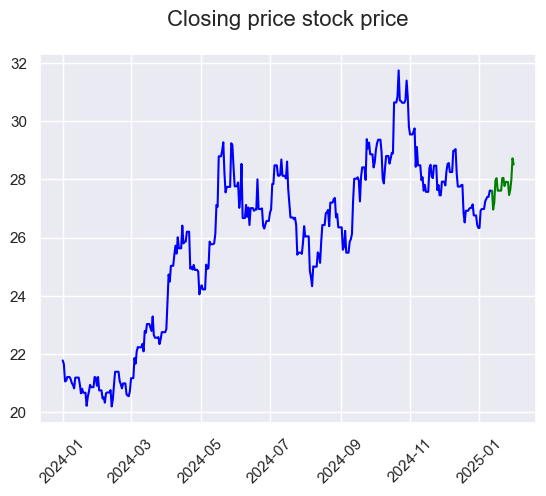

In [16]:
plt.plot(train, color="blue", label="Train Split")
plt.plot(test, color="green", label="Test Split")
plt.title("Closing price stock price", fontsize=16, pad=20)
plt.xticks(rotation=45)
plt.show()

#### ADF Test for Stationality

In [28]:
# Import Libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [30]:
# ADF Test No Difference
adf_test = adfuller(train)
print(f"p-value: {adf_test[1]}")

p-value: 0.45878542962248536


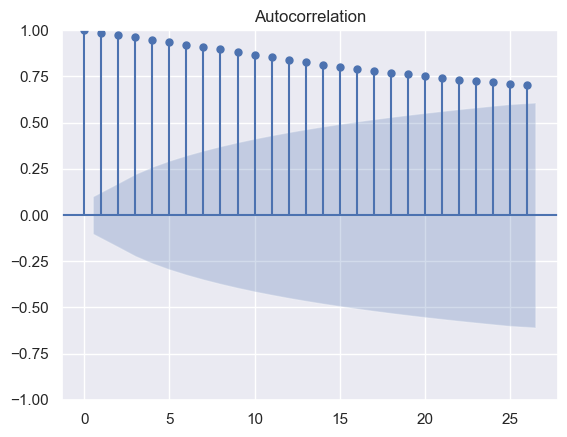

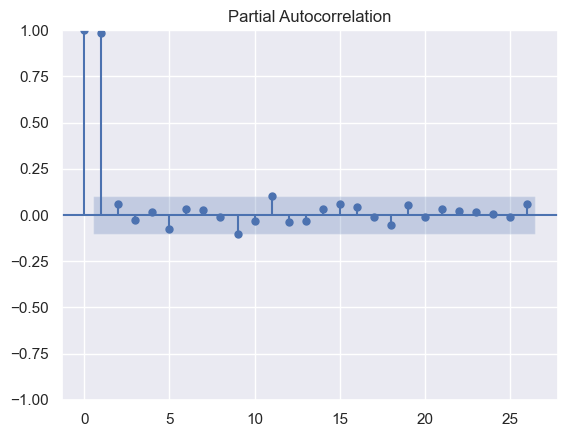

In [32]:
# Plot ACF and PCF
plot_acf(train)
plot_pacf(train)
plt.show()

<Axes: xlabel='Date'>

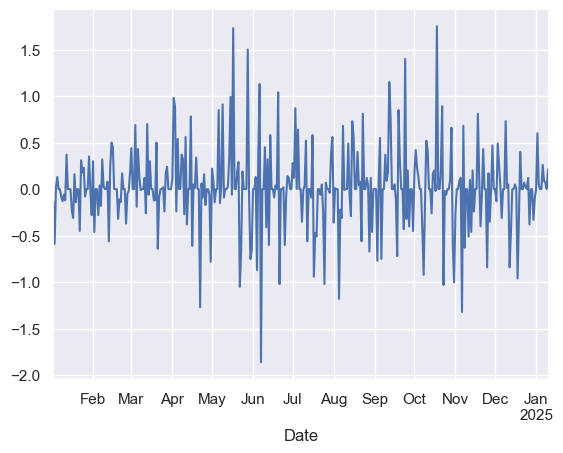

In [34]:
# ADF Test With Differencing in first order
train_df_diff = train.diff().dropna()
train_df_diff.plot()

In [36]:
# ADF Test With Differencing in first order
adf_test_diff = adfuller(train_df_diff)
print(f"p-value: {adf_test_diff[1]}")

p-value: 0.0


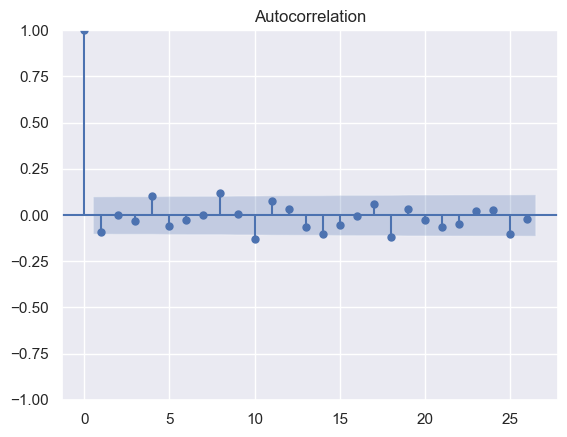

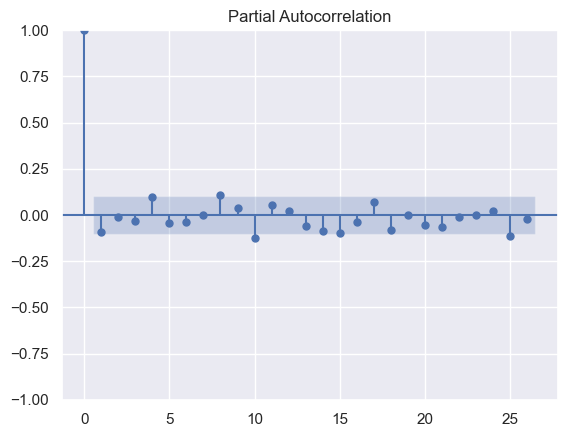

In [38]:
plot_acf(train_df_diff)
plot_pacf(train_df_diff)
plt.show()

#### Time Series Model

In [42]:
model = ARIMA(train, order=(4,1,4), freq="D")
model_fit = model.fit()
model_fit.summary()

C:\Users\jac67\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jac67\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jac67\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jac67\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  377
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -200.069
Date:                Mon, 03 Feb 2025   AIC                            418.138
Time:                        10:10:51   BIC                            453.504
Sample:                    01-01-2024   HQIC                           432.177
                         - 01-11-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0407      0.093     -0.437      0.662      -0.223       0.142
ar.L2         -0.0191      0.097     -0.197      0.844      -0.209       0.171
ar.L3          0.0095      0.097      0.097      0.922      -0.181       0.200
ar.L4          0.9695      0.095     10.215      0.000       0.783       1.155
ma.L1          0.0036      0.085      0.043      0.966      -0.164       0.171
ma.L2          0.0148      0.092      0.161      0.872      -0.166       0.196
ma.L3          0.0043      0.085      0.050      0.960      -0.161       0.170
ma.L4         -0.9622      0.092    -10.500      0.000      -1.142      -0.783
sigma2         0.1688      0.009     17.824      0.000       0.150       0.187
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):               108.84
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Residuals Plot

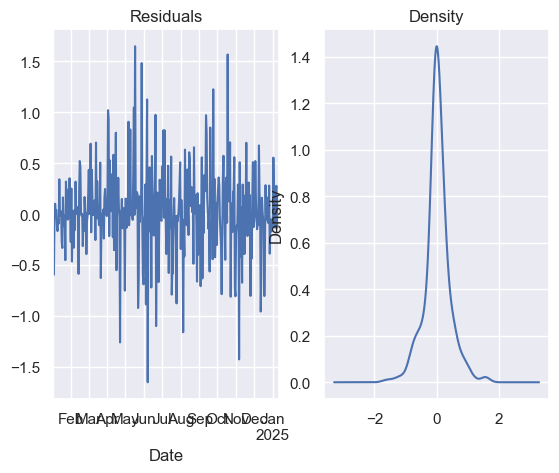

In [44]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(title="Density", kind="kde", ax=ax[1])
plt.show()

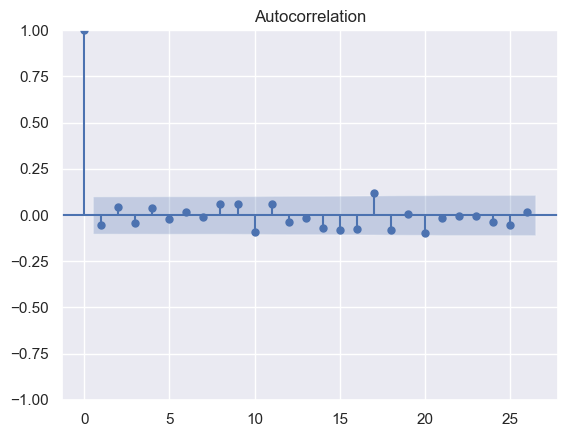

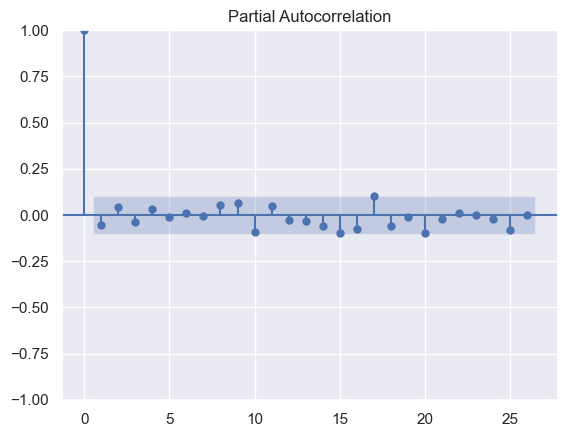

In [46]:
# ACF and PACF plots of Residuals
plot_acf(residuals)
plot_pacf(residuals)
plt.show()

#### Forecast On Testing Data With Model

In [48]:
forecast = model_fit.forecast(steps=len(test))

In [50]:
# Compare Test Data with Forecast Data
comparison = pd.DataFrame()
comparison["Test"] = test.round(2)
comparison["Forecast"] = forecast.round(2)
comparison.head()

,Test,Forecast
Date,,
2025-01-12,27.61,27.61
2025-01-13,26.96,27.75
2025-01-14,27.20,27.79
2025-01-15,27.96,27.61
2025-01-16,28.04,27.62


#### Analyze Model Performance

In [53]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
rsme = mean_squared_error(test, forecast)

print("Mean Absolute Error =", round(mae, 3))
print("Mean Absolute Percentage Error =", round(mape, 3))
print("Mean Squared Error =", round(rsme, 3))

Mean Absolute Error = 0.301
Mean Absolute Percentage Error = 0.011
Mean Squared Error = 0.172


In [55]:
# Ratio of RSME to mean of model data inputs
ratio = rsme / np.mean(model_data)

if ratio >= 0.05:
    print("There is likely medium to high error in this model. Ratio is", f"{ratio:.1%}")
else:
    print("There is likely low error in this model, as the ratio of RSME to mean of input values is", f"{ratio:.1%}")

There is likely low error in this model, as the ratio of RSME to mean of input values is 0.7%


#### Predict Future Prices

In [58]:
predicton_steps = 30
start_index = len(train) + len(test)
end_index = start_index + predicton_steps

predictions = model_fit.predict(start = start_index, end=end_index)

In [60]:
# View last five rows of future predictions
predictions.tail(15).round(2)

2025-02-17    27.66
2025-02-18    27.77
2025-02-19    27.75
2025-02-20    27.59
2025-02-21    27.66
2025-02-22    27.77
2025-02-23    27.74
2025-02-24    27.59
2025-02-25    27.67
2025-02-26    27.78
2025-02-27    27.74
2025-02-28    27.59
2025-03-01    27.67
2025-03-02    27.78
2025-03-03    27.73
Freq: D, Name: predicted_mean, dtype: float64

#### Plot Test, Train, and Forecast

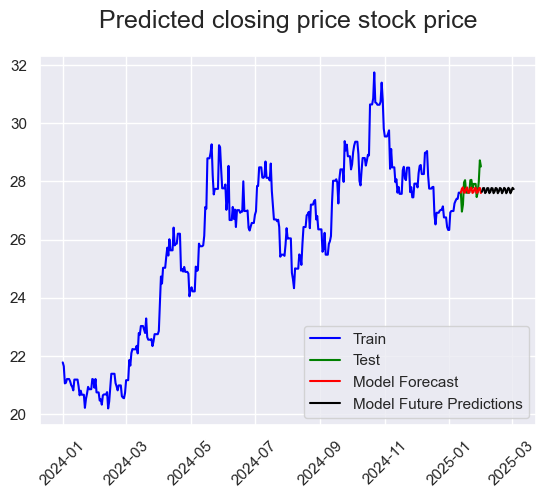

In [63]:
plt.plot(train, label="Train", color="blue")
plt.plot(test, label="Test", color="green")
plt.plot(forecast, label="Model Forecast", color="red")
plt.plot(predictions, label="Model Future Predictions", color="black")
plt.title("Predicted closing price stock price", fontsize=18, pad=20)
plt.xticks(rotation=45)
plt.legend()
plt.show()